# Census Income Project

Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

# Import necessary Python Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score,recall_score,precision_score,f1_score,mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# DATA EXPLORATION

In [3]:
#loading the data set
df = pd.read_csv(r'https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')
#print first 5 rows of the dataset
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


# Understanding the Dataset

In [4]:
#Data Summary
df.shape

(32560, 15)

In [5]:
# there are 32536 rows and 15 columns present in our dataset.

In [6]:
#finding duplicates
df.duplicated().sum()

24

In [7]:
#as we can see there are 24 duplicate columns present in the dataset, hence we shall drop them

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
#checking null values in dataset
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [10]:
# there are no null values present in our dataset

In [11]:
#checing datatypes of each column
df.dtypes.sort_values(ascending=False)

Workclass         object
Education         object
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Native_country    object
Income            object
Age                int64
Fnlwgt             int64
Education_num      int64
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
dtype: object

In [12]:
#Here Income is also considered as an Object Datatype, and hence we shall convert that into int as well.

In [13]:
#let's explore the value counts of each feature
for i in df.columns:
    print("*******************************************************")
    print("Value counts of", i, "\n" )
    print(df[i].value_counts())
    print('*******************************************************')

*******************************************************
Value counts of Age 

36    898
31    888
34    886
23    876
35    875
     ... 
83      6
85      3
88      3
86      1
87      1
Name: Age, Length: 73, dtype: int64
*******************************************************
*******************************************************
Value counts of Workclass 

 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
*******************************************************
*******************************************************
Value counts of Fnlwgt 

164190    13
203488    13
123011    13
121124    12
126675    12
          ..
154093     1
209392     1
218551     1
201204     1
145522     1
Name: Fnlwgt, Length: 21647, dtype: int64
*****************************************

# OBSERVATIONS

In [14]:
#There are 3 features where the Null values have been entered as a ?; 
#Hence, we will treat those as NaN

In [15]:
#Lets first replace '?' with np.NaN

In [16]:
df = df.replace(' ?', np.NaN)
df['Occupation'].value_counts()

 Prof-specialty       4136
 Craft-repair         4094
 Exec-managerial      4065
 Adm-clerical         3767
 Sales                3650
 Other-service        3291
 Machine-op-inspct    2000
 Transport-moving     1597
 Handlers-cleaners    1369
 Farming-fishing       992
 Tech-support          927
 Protective-serv       649
 Priv-house-serv       147
 Armed-Forces            9
Name: Occupation, dtype: int64

In [17]:
#as per above all the '?' has been replaced by np.NaN

In [18]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     582
Income               0
dtype: int64

In [19]:
#now three features, i.e. Workclass , Occupation and Native_country have null values in them. 
#We will treat the null values after we convert all of the datatypes into int/float

In [20]:
df['Workclass'].value_counts()

 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [21]:
df['Native_country'].value_counts()

 United-States                 29152
 Mexico                          639
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        62
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

# ENCODING

In [22]:
from sklearn.preprocessing import LabelEncoder
for col_name in df.columns:
    series = df[col_name]
    label_encoder = LabelEncoder()
    df[col_name] = pd.Series(
        label_encoder.fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    )

In [23]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     582
Income               0
dtype: int64

In [24]:
for i in df.columns:
    print("*******************************************************")
    print("Value counts of", i, "\n" )
    print(df[i].value_counts(dropna=False))
    print('*******************************************************')

*******************************************************
Value counts of Age 

19    898
14    888
17    886
6     876
16    875
     ... 
66      6
68      3
71      3
69      1
70      1
Name: Age, Length: 73, dtype: int64
*******************************************************
*******************************************************
Value counts of Workclass 

3.0    22673
5.0     2540
1.0     2093
NaN     1836
6.0     1297
4.0     1116
0.0      960
7.0       14
2.0        7
Name: Workclass, dtype: int64
*******************************************************
*******************************************************
Value counts of Fnlwgt 

8878     13
13073    13
5813     13
4983     12
6094     12
         ..
4516      1
6565      1
2471      1
20908     1
2047      1
Name: Fnlwgt, Length: 21647, dtype: int64
*******************************************************
*******************************************************
Value counts of Education 

11    10494
15     7282
9      5352
12

In [25]:
#Let us treat NaN values first

In [26]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     582
Income               0
dtype: int64

In [27]:
df = df.astype(np.uint8,errors='ignore')

# IMPUTATION

In [28]:
#Simple Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values= np.NaN, strategy='most_frequent')
df.Workclass = imputer.fit_transform(df['Workclass'].values.reshape(-1,1))[:,0] 

In [29]:
df.Occupation = imputer.fit_transform(df['Occupation'].values.reshape(-1,1))[:,0]

In [30]:
df.Native_country = imputer.fit_transform(df['Native_country'].values.reshape(-1,1))[:,0]

In [31]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [32]:
#lets check the statistical description of the each column
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.describe(include='all')

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
count,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000
mean,21.584245,3.094357,127.638185,10.297547,9.081725,2.611384,6.139476,1.446552,3.665816,0.669228,6.505440,2.054862,39.380778,36.419136,0.240933
std,13.633373,1.107449,74.036926,3.870195,2.571622,1.506304,3.973089,1.607087,0.848858,0.470498,23.308343,10.060266,12.143506,6.053903,0.427656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,3.000000,64.000000,9.000000,8.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,39.000000,38.000000,0.000000
50%,20.000000,3.000000,128.000000,11.000000,9.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,39.000000,38.000000,0.000000
75%,31.000000,3.000000,192.000000,12.000000,11.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,44.000000,38.000000,0.000000
max,72.000000,7.000000,255.000000,15.000000,15.000000,6.000000,13.000000,5.000000,4.000000,1.000000,118.000000,91.000000,93.000000,40.000000,1.000000


In [33]:
#all the features do not contain any null value. 
# as per the thumb rule mean>std, only capital_gain & capital_loss fail in this; Hence, they both have major skewness.

0    24697
1     7839
Name: Income, dtype: int64


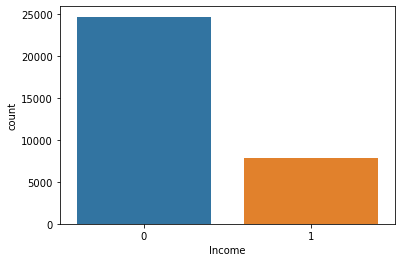

In [34]:
#count of each class (Attrition(1) = 237, NoAttrition(0)=1233)
ax=sns.countplot(x="Income", data=df)
print(df['Income'].value_counts())

In [35]:
#There is a problem of class imbalance here and hence we would have to either do upsampling or downsampling depending on the size of the dataset.

#Since the amount of upsampling needed would be around '3 times' we would be better doing downsampling to avoid any foreign data or unwanted data.

# We will peform downsampling at a later stage

<AxesSubplot:>

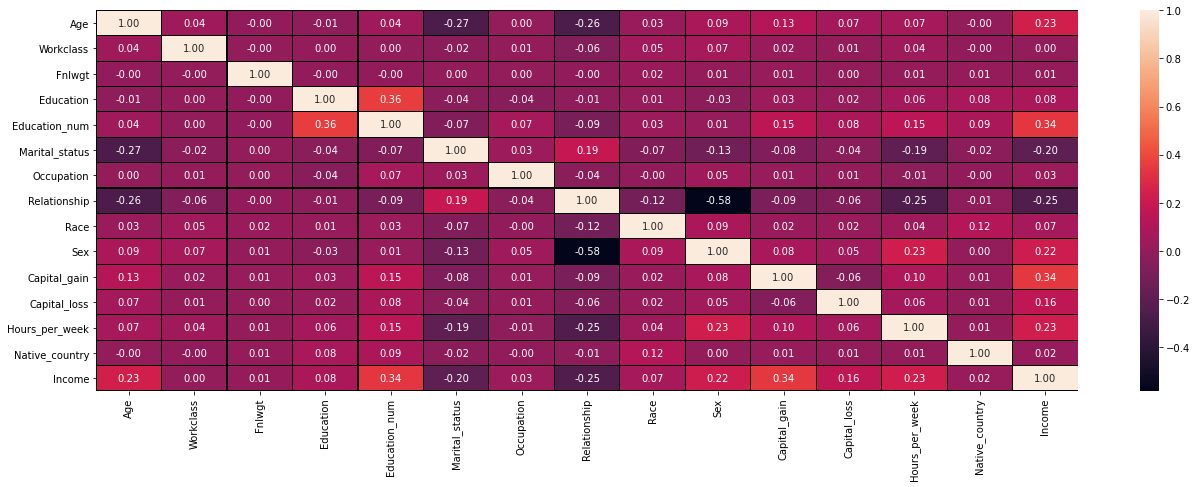

In [36]:
#Correlation using HEATMAP
import matplotlib.pyplot as plt
plt.figure(figsize=(22,7))
sns.heatmap(df.corr(),annot=True,linewidth=0.1,linecolor="black",fmt="0.2f")

In [37]:
#Correlation with the target column
corr_mat=np.abs(df.corr())
corr_mat['Income'].sort_values(ascending=False)

Income            1.000000
Capital_gain      0.340038
Education_num     0.335299
Relationship      0.250955
Age               0.234133
Hours_per_week    0.232366
Sex               0.215984
Marital_status    0.199187
Capital_loss      0.162491
Education         0.079361
Race              0.071855
Occupation        0.034490
Native_country    0.022858
Fnlwgt            0.005935
Workclass         0.002747
Name: Income, dtype: float64

In [38]:
#As per the above details, there is no feature which has high correlation with the target column.
#Also, there is no major correlaton among the features 

# DIVIDE DATA INTO FEATURES & LABEL

In [39]:
#diving the columns in feature and label
X = df.drop(columns=['Income'])
y = df['Income']

# DATA VISUALIZATION

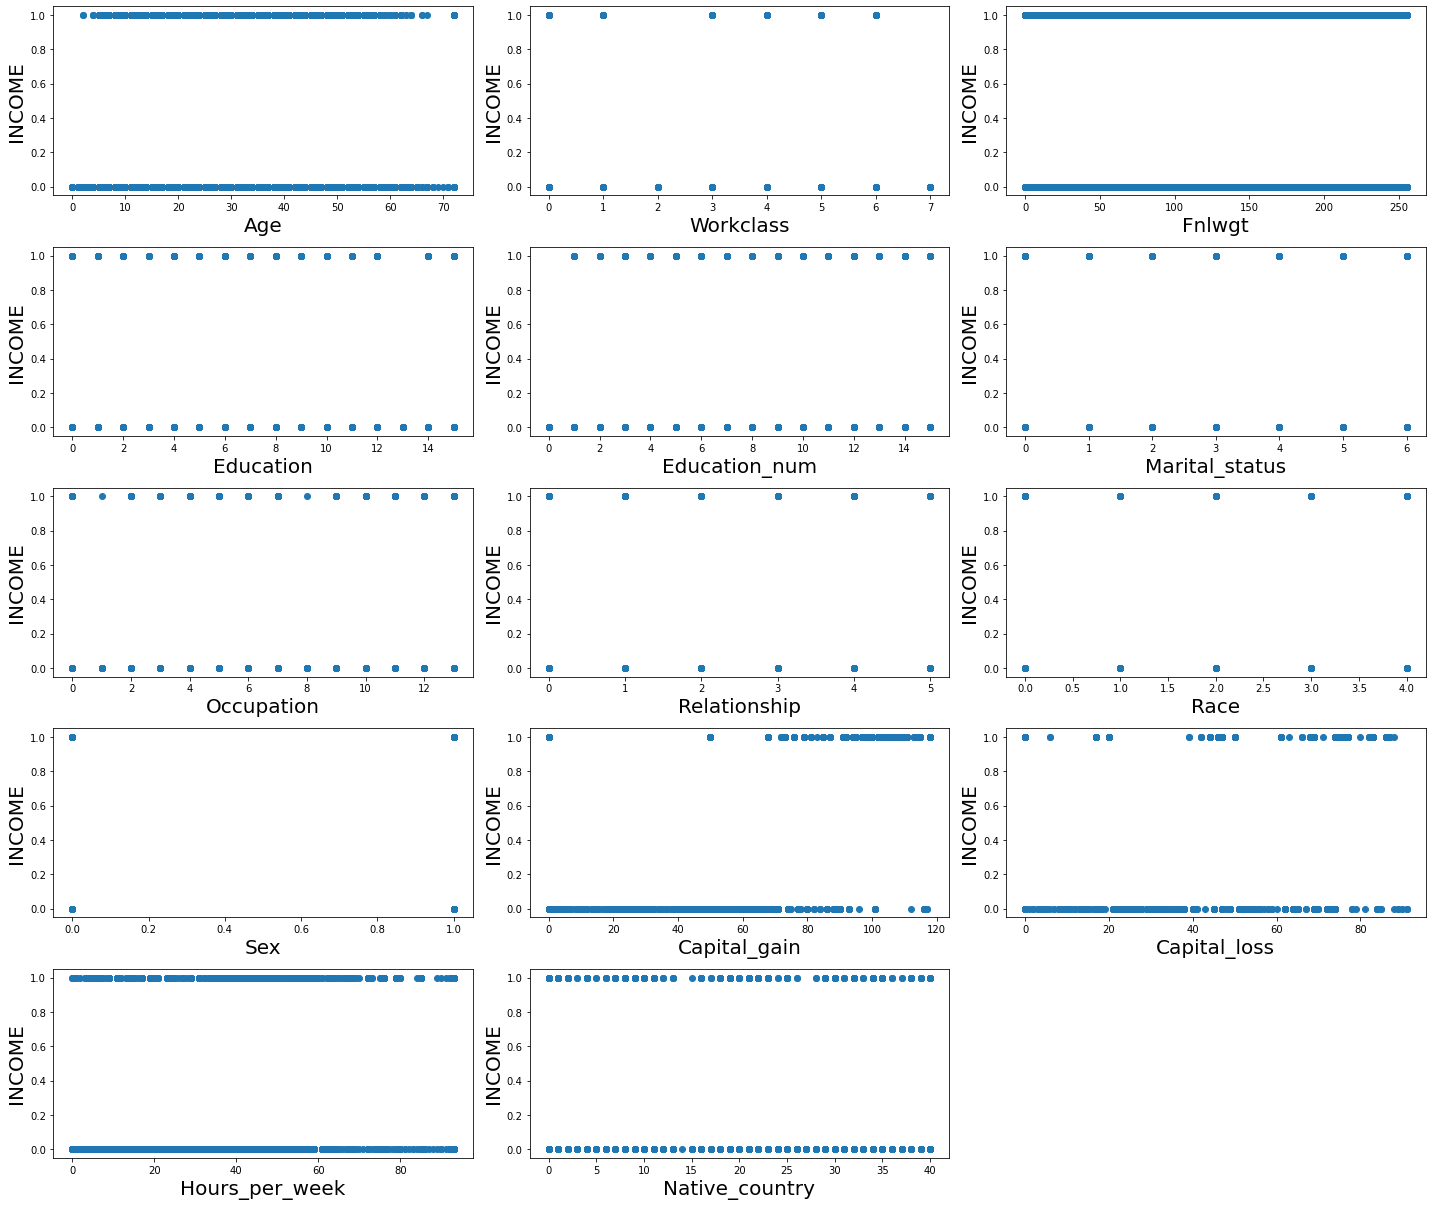

In [40]:
#Visualizing relatinship between feature and label (SCATTER PLOT)

plt.figure(figsize=(20,33),facecolor='white')
plotnumber=1

for column in X:
    if plotnumber<=30: 
        ax=plt.subplot(10,3,plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('INCOME', fontsize=20)
    plotnumber+=1
plt.tight_layout()

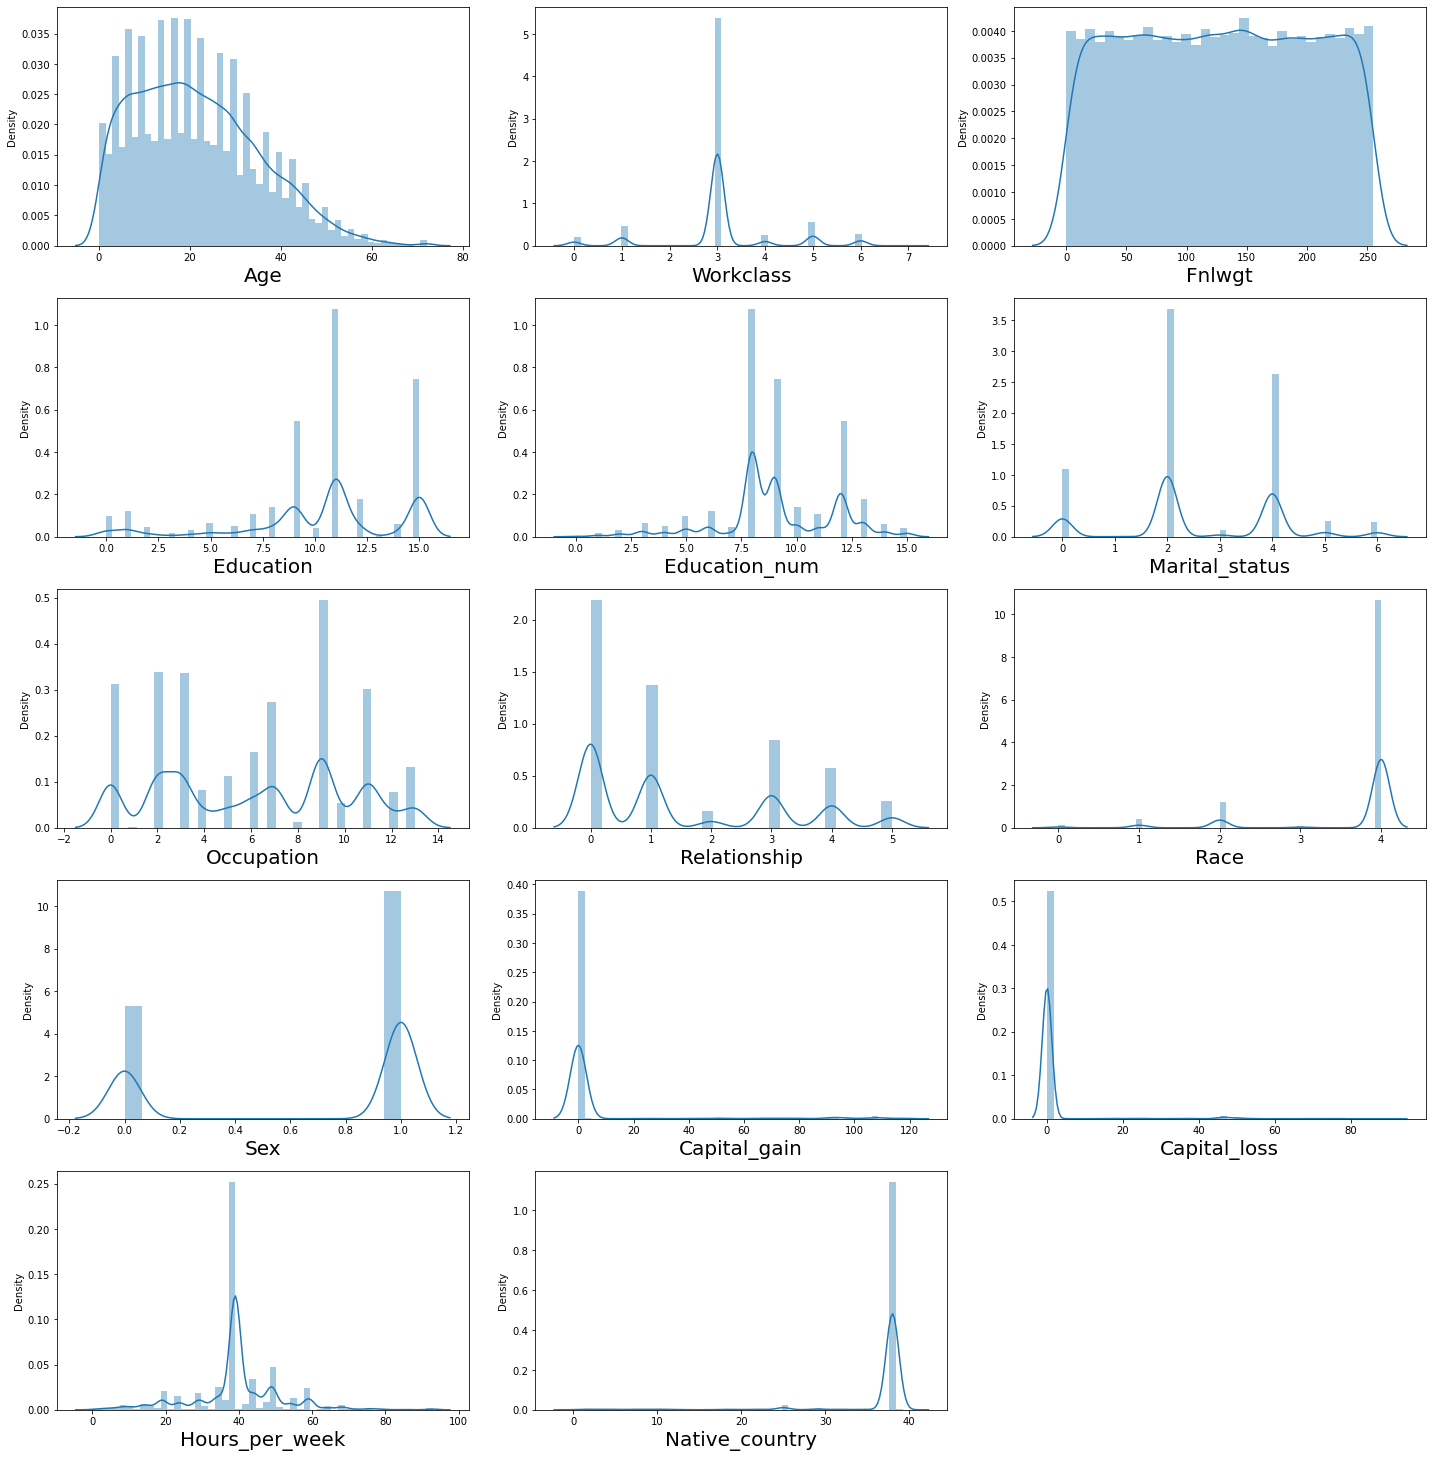

In [41]:
#Visualise the distribution of data in the feature columns(DISTRIBUTION PLOT)

plt.figure(figsize = (20,40), facecolor = 'white')
plotnumber = 1

for column in X:
    if plotnumber<=30:
        ax = plt.subplot(10,3,plotnumber)
        sns.distplot(X[column])
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.tight_layout()

In [42]:
#Checking skewness of the features
X.skew().sort_values(ascending=False)

Capital_loss      5.263914
Capital_gain      3.570576
Relationship      0.786514
Age               0.554571
Workclass         0.075983
Hours_per_week    0.070804
Occupation        0.000407
Fnlwgt            0.000286
Marital_status   -0.012692
Education_num    -0.309454
Sex              -0.719400
Education        -0.934180
Race             -2.435283
Native_country   -4.247065
dtype: float64

In [43]:
#We can see skewness in few of our columns, we will remove the skewness using power_transform function
from sklearn.preprocessing import power_transform
X_new = power_transform(X)
X=pd.DataFrame(X_new,columns=X.columns)
X.skew().sort_values(ascending=False) #validating that the skewness is removed

Capital_loss      4.297679
Capital_gain      3.015767
Workclass         0.216685
Hours_per_week    0.199655
Relationship      0.123000
Education_num     0.019607
Age              -0.104106
Marital_status   -0.114050
Occupation       -0.237229
Fnlwgt           -0.281858
Education        -0.309379
Sex              -0.719400
Race             -2.010646
Native_country   -2.984449
dtype: float64

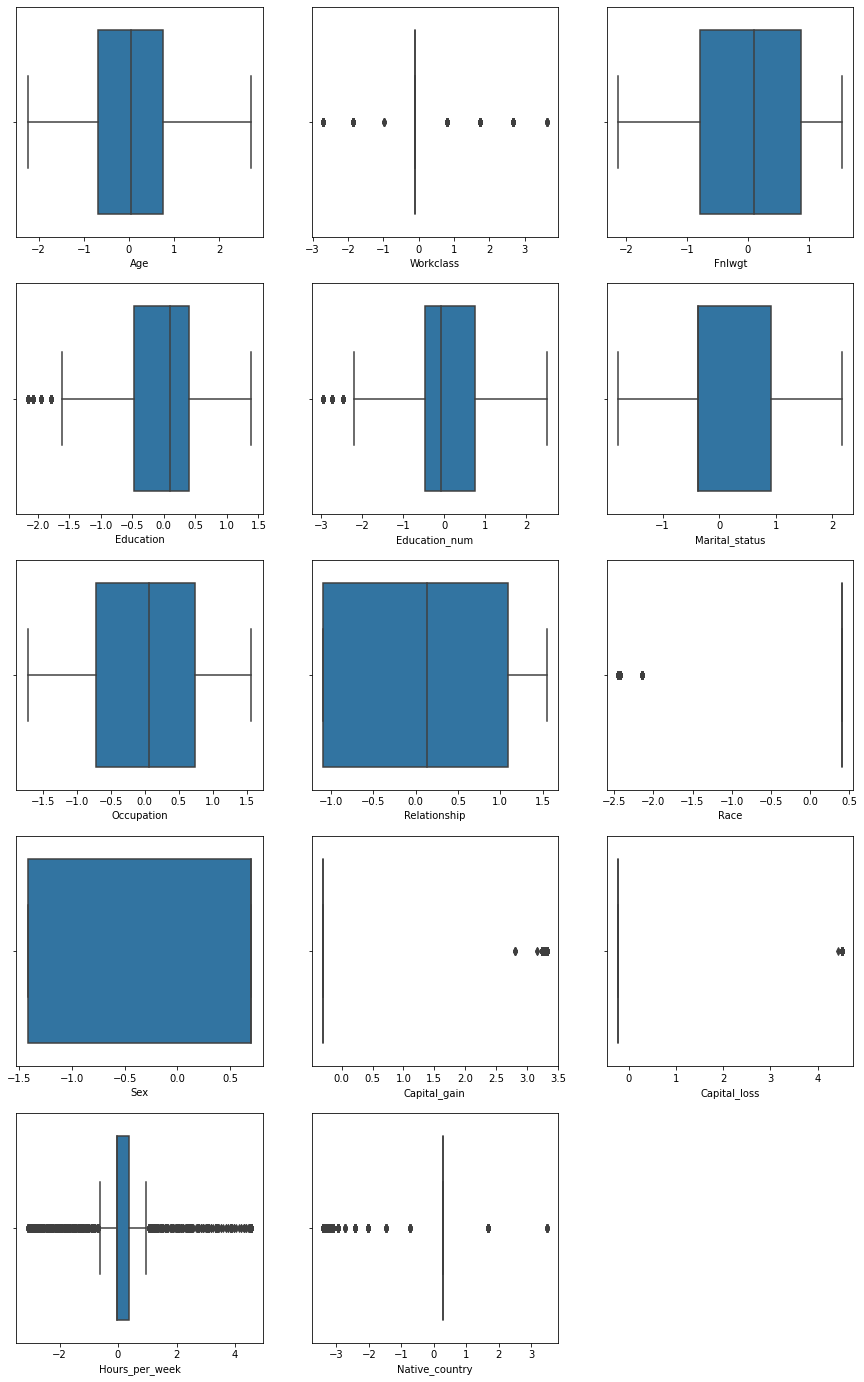

In [44]:
#Visualizing the outliers using BOXPLOT

plt.figure(figsize=(15,50))
graph=1

for column in X:
    if graph<=30: 
        ax=plt.subplot(10,3,graph)
        sns.boxplot(X[column],orient='v')
        plt.xlabel(column,fontsize=10)
    graph+=1
plt.show()

In [45]:
#We will not treat either the skewness nor the outliers because after the encoding is done, there will be abnormalities visible in the dataset.
#but this abnormality is due to the encoding and these encoded datas are important in the prediction later.

In [46]:
#Data Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [47]:
#Finding best random_state
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

maxAccu=0 #maximum accuracy
maxRS=0 #best random state value for which max accuracy is acheived 
for i in range(1,200):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predrf=LR.predict(x_test)
    acc=accuracy_score(y_test,predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is", maxAccu,"on Random State", maxRS)

Best accuracy is 0.8394283958205285 on Random State 119


In [48]:
#CREATING TRAIN-TEST SPLIT
x_train_imb, x_test, y_train_imb, y_test =  train_test_split(X, y, test_size=0.20, random_state=119)

In [49]:
print(x_train_imb.shape)
print(y_train_imb.shape)
print(x_test.shape)
print(y_test.shape)

(26028, 14)
(26028,)
(6508, 14)
(6508,)


# USING SMOTE FOR DOWN-SAMPLING

In [50]:
#conda install -c conda-forge imbalanced-learn

0    24697
1     7839
Name: Income, dtype: int64


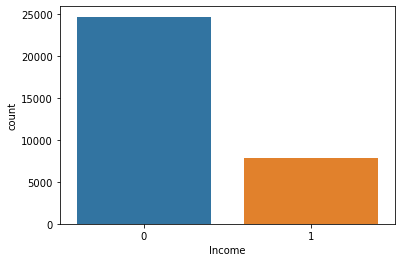

In [51]:
#count of each class (Attrition(1) = 237, NoAttrition(0)=1233)
ax=sns.countplot(x="Income", data=df)
print(df['Income'].value_counts())

In [52]:
# We will be doing down sampling of the target column which has imbalanced class

In [53]:
#USING SMOTE FOR DOWN-SAMPLING

In [54]:
print(y_train_imb.value_counts())

0    19700
1     6328
Name: Income, dtype: int64


In [55]:
#y_train has 19700 entries of class 0 and only 6328 entries of class 1

In [56]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
sm = RandomUnderSampler()
down_smp=RandomUnderSampler(0.99)
x_train_ns,y_train_ns=down_smp.fit_sample(x_train_imb,y_train_imb)
from collections import Counter
print('The no of samples before fit()', format(Counter(y_train_imb)))
print('The no of samples after fit()', format(Counter(y_train_ns)))

The no of samples before fit() Counter({0: 19700, 1: 6328})
The no of samples after fit() Counter({0: 6391, 1: 6328})


In [57]:
print(y_train_ns.value_counts())

0    6391
1    6328
Name: Income, dtype: int64


In [58]:
#Now both the classes have 6391 and 6328 entries and hence we have a balanced class in our training data.

In [59]:
# Using shallow copy or deep copy
import copy
x_train = copy.copy(x_train_ns)
y_train = copy.copy(y_train_ns)

In [60]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12719, 14)
(12719,)
(6508, 14)
(6508,)


# APPLYING CLASSIFICATION MODELS & FINDING BEST FIT MODEL

In [61]:
results = pd.DataFrame()
model_name=[]
accuracy=[]
cvs=[]

In [62]:
#LOGISTIC REGRESSION
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred=LR.predict(x_test)
accuracy_LR = accuracy_score(y_test,y_pred)*100
scr = cross_val_score(LR,X,y,cv=5)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
model_name.append("Logistic Regression")
accuracy.append(accuracy_LR)
cvs.append(scr.mean())

[[3815 1182]
 [ 283 1228]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4997
           1       0.51      0.81      0.63      1511

    accuracy                           0.77      6508
   macro avg       0.72      0.79      0.73      6508
weighted avg       0.83      0.77      0.79      6508



In [63]:
#DECISION TREE CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
accuracy_dt = accuracy_score(y_test,y_pred_dt)*100
scr2 = cross_val_score(dt,X,y,cv=5)
print(confusion_matrix(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))
model_name.append("Decistion Tree Classifier")
accuracy.append(accuracy_dt)
cvs.append(scr2.mean())

[[3780 1217]
 [ 347 1164]]
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      4997
           1       0.49      0.77      0.60      1511

    accuracy                           0.76      6508
   macro avg       0.70      0.76      0.71      6508
weighted avg       0.82      0.76      0.78      6508



In [64]:
#RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
accuracy_rf = accuracy_score(y_test,y_pred_rf)*100
scr3 = cross_val_score(rf,X,y,cv=5)
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
model_name.append("Random Forest Classifier")
accuracy.append(accuracy_rf)
cvs.append(scr3.mean())

[[3969 1028]
 [ 216 1295]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4997
           1       0.56      0.86      0.68      1511

    accuracy                           0.81      6508
   macro avg       0.75      0.83      0.77      6508
weighted avg       0.86      0.81      0.82      6508



In [65]:
#SVC
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
accuracy_svc = accuracy_score(y_test,y_pred_svc)*100
scr4 = cross_val_score(svc,X,y,cv=5)
print(confusion_matrix(y_test,y_pred_svc))
print(classification_report(y_test,y_pred_svc))
model_name.append("SVC")
accuracy.append(accuracy_svc)
cvs.append(scr4.mean())

[[3700 1297]
 [ 168 1343]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.83      4997
           1       0.51      0.89      0.65      1511

    accuracy                           0.77      6508
   macro avg       0.73      0.81      0.74      6508
weighted avg       0.85      0.77      0.79      6508



In [66]:
results['Model Name'] = model_name
results['Accuracy'] = accuracy
results['Cross Value Score'] = cvs
results

,Model Name,Accuracy,Cross Value Score
0,Logistic Regression,77.489244,0.825025
1,Decistion Tree Classifier,75.968039,0.804309
2,Random Forest Classifier,80.885065,0.852502
3,SVC,77.489244,0.834737


In [ ]:
#As per the above results, Random Forest Classifier is giving the best accuracy.

In [ ]:
#Lets try to improve the accuracy score by using GridSearchCV over RF classifier

In [67]:
#Let's tune the parameter using GridSearchCV
#RandomForestClassifier
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=41)
clf= RandomForestClassifier()
params = { 'n_estimators': [13,15],
          'criterion': ['entropy', 'gini'],
          'max_depth': [10,15],
          'min_samples_split':[10,11],
          'min_samples_leaf':[5,6]
         }
grid=GridSearchCV(clf,param_grid=params)
grid.fit(x_train,y_train)
print('best_params=>', grid.best_params_)
clf=grid.best_estimator_
clf.fit(x_train,y_train)
y_pred_gscv=clf.predict(x_test)
rf_conf_mat=confusion_matrix(y_test,y_pred_gscv)
print('\n Conf Mat =>''\n', rf_conf_mat)
print('\n' ' Accuracy rf Normal =>', accuracy_score(y_test,y_pred_gscv))

report = classification_report(y_test,y_pred_gscv)
print(report)

best_params=> {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 15}

 Conf Mat =>
 [[6970  470]
 [ 924 1397]]

 Accuracy rf Normal => 0.8571867636512652
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7440
           1       0.75      0.60      0.67      2321

    accuracy                           0.86      9761
   macro avg       0.82      0.77      0.79      9761
weighted avg       0.85      0.86      0.85      9761



# Concluding Remarks

Since Random Forest Regression model has the best score, we will finalise the model.

# SAVE THE MODEL

In [68]:
import joblib
joblib.dump(clf,'Census_Income_Project.obj')

['Census_Income_Project.obj']